## Data Distribution

In [1]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import matplotlib.pyplot as plt
from CNN.utility import train_routine
from CNN.loader import load_dataset, get_split
from sklearn.manifold import TSNE


SPLIT_PERC = {'train': 0.8, 'val': 0.2}
DATA_DIR = os.path.join('data', 'mammals_calls')
TO_TRAIN = True
h = 164
w = 397

seed = 2025
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

2025-09-11 10:53:51.601030: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


GPUs found: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPUs found: 1
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [2]:
subfolders = [f.path for f in os.scandir(DATA_DIR) if f.is_dir()]
data_info = {}
for subfolder in subfolders:
    species_name = os.path.basename(subfolder)
    file_count = len([f for f in os.listdir(subfolder) if os.path.isfile(os.path.join(subfolder, f))])
    data_info[species_name] = file_count
count_df = pd.DataFrame(list(data_info.items()), columns=['species', 'file_count'])
count_df = count_df.sort_values(by='file_count', ascending=False)


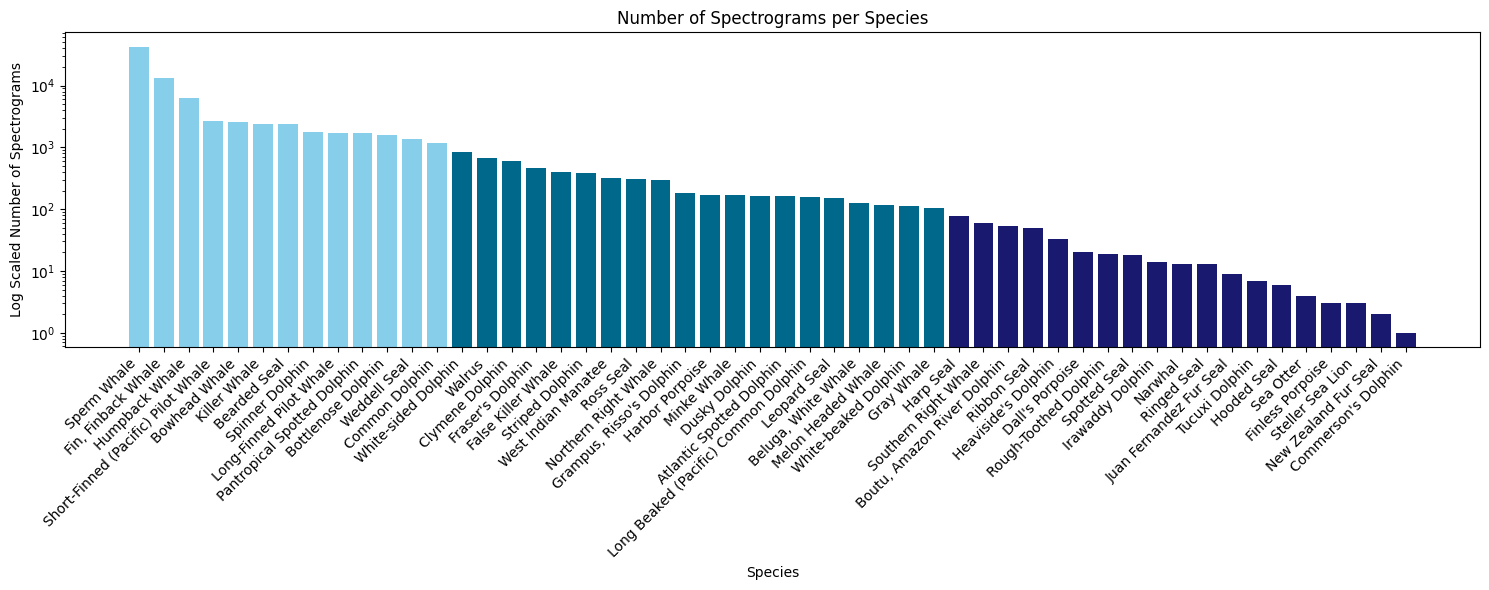

Total number of species: 52
Number of species with more than 1000 spectrograms: 13
Number of species with more than 100 but less than 1000 spectrograms: 20
Number of species with less than 100 spectrograms: 19


In [3]:
count_thousands = count_df[count_df['file_count'] > 1000]
count_hundreds = count_df[(count_df['file_count'] > 100) & (count_df['file_count'] < 1000)]
count_tens = count_df[count_df['file_count'] < 100]

plt.figure(figsize=(15, 6))
plt.bar(count_thousands['species'], count_thousands['file_count'], color="#87CEEB")
plt.bar(count_hundreds['species'], count_hundreds['file_count'], color='#00688B')
plt.bar(count_tens['species'], count_tens['file_count'], color="#191970")
plt.xlabel('Species')
plt.xticks(rotation=45, ha='right')
plt.ylabel('Log Scaled Number of Spectrograms')
plt.yscale("log")
plt.title('Number of Spectrograms per Species')

plt.tight_layout()
plt.show()

print(f'Total number of species: {count_df.shape[0]}')
print(f'Number of species with more than 1000 spectrograms: {count_thousands.shape[0]}')
print(f'Number of species with more than 100 but less than 1000 spectrograms: {count_hundreds.shape[0]}')
print(f'Number of species with less than 100 spectrograms: {count_tens.shape[0]}')


## Training CNN

In [4]:
CNN_CACHE_DIR = os.path.join("data_cache", "CNN")
MODELS_METRICS_DIR = os.path.join("models_metrics")
PATIENCE = 3
if not os.path.exists(MODELS_METRICS_DIR):
    os.makedirs(MODELS_METRICS_DIR)

split_perc = {'train': 0.8, 'val': 0.2}

Training della CNN classica con le classi che contengono più di 1000 sample.

In [5]:

n_classes_1000 = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (0, 0), to_train=TO_TRAIN, cardinality=999)

Total classes found: 13
Listing all image files path...
Creating and caching data split...
Processing train set with 65128 images...


I0000 00:00:1757588036.584625    1417 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13759 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5


train set processed and added to the dictionary.
Processing val set with 16282 images...
val set processed and added to the dictionary.
training
Epoch 1/50


2025-09-11 10:54:05.740000: I external/local_xla/xla/service/service.cc:163] XLA service 0x7e15c4008f50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-11 10:54:05.740028: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
2025-09-11 10:54:05.925983: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-11 10:54:06.354450: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-09-11 10:54:07.306401: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,99,41]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,99,41]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$

   3/2036 ━━━━━━━━━━━━━━━━━━━━ 2:35 77ms/step - accuracy: 0.2222 - loss: 3.3727  

I0000 00:00:1757588052.327942    1455 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2035/2036 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.8498 - loss: 0.4905

2025-09-11 10:58:49.446411: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[8,64,99,41]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,32,99,41]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-09-11 10:58:49.507217: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[8,128,49,20]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,49,20]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cu

2036/2036 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.8498 - loss: 0.4904

2025-09-11 10:58:58.543256: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,64,99,41]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,32,99,41]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-09-11 10:58:58.715466: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[32,128,49,20]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,64,49,20]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="

2036/2036 ━━━━━━━━━━━━━━━━━━━━ 474s 226ms/step - accuracy: 0.8872 - loss: 0.3230 - val_accuracy: 0.8133 - val_loss: 1.3355
Epoch 2/50


2025-09-11 11:01:52.920466: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2036/2036 ━━━━━━━━━━━━━━━━━━━━ 453s 221ms/step - accuracy: 0.9161 - loss: 0.1958 - val_accuracy: 0.8921 - val_loss: 0.4251
Epoch 3/50


2025-09-11 11:09:25.580787: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2036/2036 ━━━━━━━━━━━━━━━━━━━━ 446s 217ms/step - accuracy: 0.9220 - loss: 0.1714 - val_accuracy: 0.9103 - val_loss: 0.2107
Epoch 4/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 448s 218ms/step - accuracy: 0.9254 - loss: 0.1516 - val_accuracy: 0.9060 - val_loss: 0.2162
Epoch 5/50


2025-09-11 11:24:19.697592: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2036/2036 ━━━━━━━━━━━━━━━━━━━━ 441s 215ms/step - accuracy: 0.9269 - loss: 0.1427 - val_accuracy: 0.9151 - val_loss: 0.2545
Epoch 6/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 452s 220ms/step - accuracy: 0.9289 - loss: 0.1392 - val_accuracy: 0.8455 - val_loss: 0.5047
Epoch 7/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 448s 218ms/step - accuracy: 0.9296 - loss: 0.1347 - val_accuracy: 0.8989 - val_loss: 0.8056
Epoch 8/50
2036/2036 ━━━━━━━━━━━━━━━━━━━━ 449s 219ms/step - accuracy: 0.9302 - loss: 0.1297 - val_accuracy: 0.9064 - val_loss: 0.3216


2025-09-11 11:54:08.989203: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


{'accuracy': [0.8871913552284241, 0.9161036610603333, 0.9219997525215149, 0.9254391193389893, 0.9268670678138733, 0.9289092421531677, 0.9295694828033447, 0.9301682710647583], 'loss': [0.32298585772514343, 0.19580121338367462, 0.17135697603225708, 0.15155044198036194, 0.14269708096981049, 0.1392478048801422, 0.13472363352775574, 0.12972193956375122], 'val_accuracy': [0.8132907748222351, 0.8920894265174866, 0.9103304147720337, 0.9059697985649109, 0.9151210188865662, 0.8454735279083252, 0.8989067673683167, 0.9063997268676758], 'val_loss': [1.3355234861373901, 0.4251026511192322, 0.21071955561637878, 0.21618659794330597, 0.25452283024787903, 0.5047483444213867, 0.8055537343025208, 0.3215658664703369]}
Moved cached data to models_metrics directory.


Si ripete il training aggiungendo 10 classi per volta in ordine decrescente in numero di sample contenuti.

In [6]:
#Fino a classe 23
n_classes_plus_10 = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (n_classes_1000, 10), to_train=TO_TRAIN)

Added classes: ['White-sided Dolphin', 'Walrus', 'Clymene Dolphin', "Fraser's Dolphin", 'False Killer Whale', 'Striped Dolphin', 'West Indian Manatee', 'Ross Seal', 'Northern Right Whale', "Grampus, Risso's Dolphin"]
Total classes found: 23
Listing all image files path...
Creating and caching data split...
Processing train set with 68728 images...
train set processed and added to the dictionary.
Processing val set with 17182 images...
val set processed and added to the dictionary.
training
Epoch 1/50
2147/2148 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8182 - loss: 0.6581

2025-09-11 11:59:06.088347: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[24,64,99,41]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,32,99,41]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-09-11 11:59:06.202899: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[24,128,49,20]{3,2,1,0}, u8[0]{0}) custom-call(f32[24,64,49,20]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="

2148/2148 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8182 - loss: 0.6580

2025-09-11 12:00:15.866649: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[30,64,99,41]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,32,99,41]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-09-11 12:00:16.016294: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[30,128,49,20]{3,2,1,0}, u8[0]{0}) custom-call(f32[30,64,49,20]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="

2148/2148 ━━━━━━━━━━━━━━━━━━━━ 490s 223ms/step - accuracy: 0.8621 - loss: 0.4410 - val_accuracy: 0.8945 - val_loss: 0.3150
Epoch 2/50
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 493s 228ms/step - accuracy: 0.9067 - loss: 0.2319 - val_accuracy: 0.8858 - val_loss: 0.5474
Epoch 3/50
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 491s 227ms/step - accuracy: 0.9166 - loss: 0.1921 - val_accuracy: 0.9059 - val_loss: 0.2649
Epoch 4/50
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 475s 219ms/step - accuracy: 0.9208 - loss: 0.1676 - val_accuracy: 0.9158 - val_loss: 0.3721
Epoch 5/50
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 478s 221ms/step - accuracy: 0.9234 - loss: 0.1572 - val_accuracy: 0.9112 - val_loss: 0.3483
Epoch 6/50
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 478s 221ms/step - accuracy: 0.9253 - loss: 0.1493 - val_accuracy: 0.8827 - val_loss: 1.1455
Epoch 7/50
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 469s 217ms/step - accuracy: 0.9282 - loss: 0.1407 - val_accuracy: 0.9172 - val_loss: 0.1813
Epoch 8/50
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 482s 223ms/step - accuracy: 0.9

2025-09-11 12:58:27.067729: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2148/2148 ━━━━━━━━━━━━━━━━━━━━ 475s 219ms/step - accuracy: 0.9312 - loss: 0.1298 - val_accuracy: 0.9106 - val_loss: 0.8755
Epoch 10/50
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 483s 223ms/step - accuracy: 0.9311 - loss: 0.1300 - val_accuracy: 0.8893 - val_loss: 2.6792
Epoch 11/50
2148/2148 ━━━━━━━━━━━━━━━━━━━━ 482s 222ms/step - accuracy: 0.9314 - loss: 0.1260 - val_accuracy: 0.9095 - val_loss: 1.4729


{'accuracy': [0.8620940446853638, 0.9067046642303467, 0.9166133403778076, 0.9207600951194763, 0.9234227538108826, 0.925256073474884, 0.9281660914421082, 0.9296793341636658, 0.9311925172805786, 0.9311197996139526, 0.9313525557518005], 'loss': [0.4410199224948883, 0.23194938898086548, 0.1920621693134308, 0.16761867702007294, 0.15723876655101776, 0.14933454990386963, 0.1406913846731186, 0.13504208624362946, 0.1297958940267563, 0.12997449934482574, 0.12598837912082672], 'val_accuracy': [0.8944826126098633, 0.8858107328414917, 0.9058898687362671, 0.9158421754837036, 0.9111860990524292, 0.8827261328697205, 0.9171807765960693, 0.9186357855796814, 0.9106041193008423, 0.8893027305603027, 0.9094983339309692], 'val_loss': [0.3150457441806793, 0.5473592281341553, 0.26492488384246826, 0.3720613420009613, 0.3482559621334076, 1.145538091659546, 0.18134914338588715, 0.16758479177951813, 0.8755481243133545, 2.6791532039642334, 1.4729195833206177]}
Moved cached data to models_metrics directory.


In [7]:
#Fino a classe 33
n_classes_plus_20 = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (n_classes_plus_10, 10), to_train=TO_TRAIN)

Added classes: ['Harbor Porpoise', 'Minke Whale', 'Dusky Dolphin', 'Atlantic Spotted Dolphin', 'Long Beaked (Pacific) Common Dolphin', 'Leopard Seal', 'Beluga, White Whale', 'Melon Headed Whale', 'White-beaked Dolphin', 'Gray Whale']
Total classes found: 33
Listing all image files path...
Creating and caching data split...
Processing train set with 69880 images...
train set processed and added to the dictionary.
Processing val set with 17470 images...
val set processed and added to the dictionary.
training
Epoch 1/50
2184/2184 ━━━━━━━━━━━━━━━━━━━━ 505s 226ms/step - accuracy: 0.8520 - loss: 0.4912 - val_accuracy: 0.8025 - val_loss: 0.7231
Epoch 2/50
2184/2184 ━━━━━━━━━━━━━━━━━━━━ 483s 219ms/step - accuracy: 0.8992 - loss: 0.2754 - val_accuracy: 0.8540 - val_loss: 0.5313
Epoch 3/50
2184/2184 ━━━━━━━━━━━━━━━━━━━━ 484s 220ms/step - accuracy: 0.9107 - loss: 0.2180 - val_accuracy: 0.7286 - val_loss: 1.5230
Epoch 4/50
2184/2184 ━━━━━━━━━━━━━━━━━━━━ 479s 218ms/step - accuracy: 0.9170 - loss: 0

{'accuracy': [0.8520034551620483, 0.8991699814796448, 0.9106611609458923, 0.9170148968696594, 0.9215226173400879, 0.9255580902099609, 0.9261877536773682, 0.9281339645385742, 0.9284917116165161, 0.9306668639183044, 0.9321694374084473], 'loss': [0.4911923110485077, 0.2754473388195038, 0.21796143054962158, 0.18842138350009918, 0.16791264712810516, 0.1564248949289322, 0.14814268052577972, 0.1448996216058731, 0.13997814059257507, 0.1366182416677475, 0.1318870484828949], 'val_accuracy': [0.8024613857269287, 0.8539782762527466, 0.7285632491111755, 0.902518630027771, 0.9087006449699402, 0.8871780037879944, 0.8718946576118469, 0.9153978228569031, 0.9157984852790833, 0.9072123765945435, 0.7516313791275024], 'val_loss': [0.7230647206306458, 0.5313411951065063, 1.5229796171188354, 0.27770522236824036, 0.26302215456962585, 0.3176622688770294, 0.38722604513168335, 0.1792469471693039, 0.15411609411239624, 0.17024913430213928, 9.707149505615234]}
Moved cached data to models_metrics directory.


In [8]:
#Fino a classe 43
n_classes_plus_30 = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (n_classes_plus_20, 10), to_train=TO_TRAIN)

Added classes: ['Harp Seal', 'Southern Right Whale', 'Boutu, Amazon River Dolphin', 'Ribbon Seal', "Heaviside's Dolphin", "Dall's Porpoise", 'Rough-Toothed Dolphin', 'Spotted Seal', 'Irawaddy Dolphin', 'Narwhal']
Total classes found: 43
Listing all image files path...
Creating and caching data split...
Processing train set with 70165 images...
train set processed and added to the dictionary.
Processing val set with 17541 images...
val set processed and added to the dictionary.
training
Epoch 1/50
2192/2193 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.8102 - loss: 0.7392

2025-09-11 14:56:41.657841: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[21,64,99,41]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,32,99,41]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-09-11 14:56:41.770220: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[21,128,49,20]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,64,49,20]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="

2193/2193 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.8103 - loss: 0.7391

2025-09-11 14:57:52.700282: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[5,64,99,41]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,32,99,41]{3,2,1,0}, f32[64,32,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-09-11 14:57:52.770155: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[5,128,49,20]{3,2,1,0}, u8[0]{0}) custom-call(f32[5,64,49,20]{3,2,1,0}, f32[128,64,3,3]{3,2,1,0}, f32[128]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cu

2193/2193 ━━━━━━━━━━━━━━━━━━━━ 501s 224ms/step - accuracy: 0.8535 - loss: 0.5084 - val_accuracy: 0.3305 - val_loss: 3.6487
Epoch 2/50
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 491s 222ms/step - accuracy: 0.8991 - loss: 0.2828 - val_accuracy: 0.8966 - val_loss: 0.3684
Epoch 3/50


2025-09-11 15:08:18.792053: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


2193/2193 ━━━━━━━━━━━━━━━━━━━━ 489s 221ms/step - accuracy: 0.9097 - loss: 0.2251 - val_accuracy: 0.4848 - val_loss: 4.5229
Epoch 4/50
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 490s 221ms/step - accuracy: 0.9160 - loss: 0.1985 - val_accuracy: 0.9038 - val_loss: 0.2800
Epoch 5/50
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 485s 220ms/step - accuracy: 0.9208 - loss: 0.1792 - val_accuracy: 0.8952 - val_loss: 0.3046
Epoch 6/50
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 488s 221ms/step - accuracy: 0.9245 - loss: 0.1636 - val_accuracy: 0.9013 - val_loss: 0.2487
Epoch 7/50
2193/2193 ━━━━━━━━━━━━━━━━━━━━ 493s 223ms/step - accuracy: 0.9261 - loss: 0.1555 - val_accuracy: 0.9005 - val_loss: 0.2769


{'accuracy': [0.8535024523735046, 0.8991377353668213, 0.9096558094024658, 0.9159694910049438, 0.9208152294158936, 0.9244922399520874, 0.9260600209236145], 'loss': [0.5084471106529236, 0.2828471064567566, 0.22512546181678772, 0.19848094880580902, 0.17915238440036774, 0.16362260282039642, 0.1555255949497223], 'val_accuracy': [0.33053988218307495, 0.8965851664543152, 0.48480701446533203, 0.9037683010101318, 0.8952169418334961, 0.9012598991394043, 0.9005187749862671], 'val_loss': [3.6487135887145996, 0.36842745542526245, 4.522871971130371, 0.28004103899002075, 0.30455252528190613, 0.24868592619895935, 0.27692219614982605]}
Moved cached data to models_metrics directory.


In [9]:
#Fino all'ultima classe
n_classes_plus_rem = train_routine(count_df, PATIENCE, SPLIT_PERC, DATA_DIR, (w, h), (n_classes_plus_30, 10), to_train=TO_TRAIN)

Added classes: ['Ringed Seal', 'Juan Fernandez Fur Seal', 'Tucuxi Dolphin', 'Hooded Seal', 'Sea Otter', 'Finless Porpoise', 'Steller Sea Lion', 'New Zealand Fur Seal']
Total classes found: 51
Listing all image files path...
Creating and caching data split...
Processing train set with 70203 images...
train set processed and added to the dictionary.
Processing val set with 17550 images...
val set processed and added to the dictionary.
training
Epoch 1/50
 259/2194 ━━━━━━━━━━━━━━━━━━━━ 4:15 132ms/step - accuracy: 0.6633 - loss: 1.6697

KeyboardInterrupt: 

## Output Plots

In [15]:
def get_class_metrics(row, all_classes_df, metrics_list):
    for metric in metrics_list:
        class_num = row['index']
        col_name = rf'{class_num}_{metric}'
        class_metrics = all_classes_df[col_name]
        row[metric] = class_metrics
    return row

def process_metrics(n_classes, training_date):
    all_classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, f'{training_date}_training', f'{n_classes}_CNN_metrics.csv'))
    all_classes_df = all_classes_df.loc[:, all_classes_df.columns.str.match(r'^\d')]
    last_epoch_metrics = all_classes_df.iloc[-1]

    classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, f'{training_date}_training', f'{n_classes}_label_to_index.csv'))

    metrics_list = ['precision', 'recall', 'f1-score', 'support']
    classes_df = classes_df.apply(get_class_metrics, axis=1, all_classes_df=last_epoch_metrics, metrics_list=metrics_list)
    classes_df['label'] = classes_df['label'].apply(lambda x: ' '.join(x.split(' ')[:2]) if len(x) > 20 else x)
    classes_df.to_csv(os.path.join(MODELS_METRICS_DIR, f'{training_date}_merged_metrics', f'{n_classes}_merged_metrics.csv'), index=False)

def metrics_plot_builder(metrics_df):
    metrics_list = ['precision', 'recall', 'f1-score']
    f = 1
    fig = plt.figure(figsize=(15, 15))
    for metric in metrics_list:
        axs = plt.subplot(2, 2, f)
        axs.bar(metrics_df['label'], metrics_df[metric], color="#87CEEB")
        for i, (metric_value, support) in enumerate(zip(metrics_df[metric], metrics_df['support'])):
            label_pos = metric_value - (metric_value/2) if metric_value > 0 else metric_value + 0.02
            plt.text(i, label_pos, f'n:{int(support)}', ha='center', va='bottom', fontsize=9, rotation=90)
        axs.set_xlabel('Class')
        axs.tick_params(axis='x', rotation=90)
        axs.set_ylabel(metric.capitalize())
        axs.set_title(f'{metric.capitalize()} per Class (ordered by Support - descending)')
        
        f += 1
    fig.tight_layout()
    return fig

In [17]:
curr_training_date = '11-09'
process_metrics(n_classes_1000, curr_training_date)
process_metrics(n_classes_plus_10, curr_training_date)
process_metrics(n_classes_plus_20, curr_training_date)
process_metrics(n_classes_plus_30, curr_training_date)
#process_metrics(n_classes_plus_rem, curr_training_date)

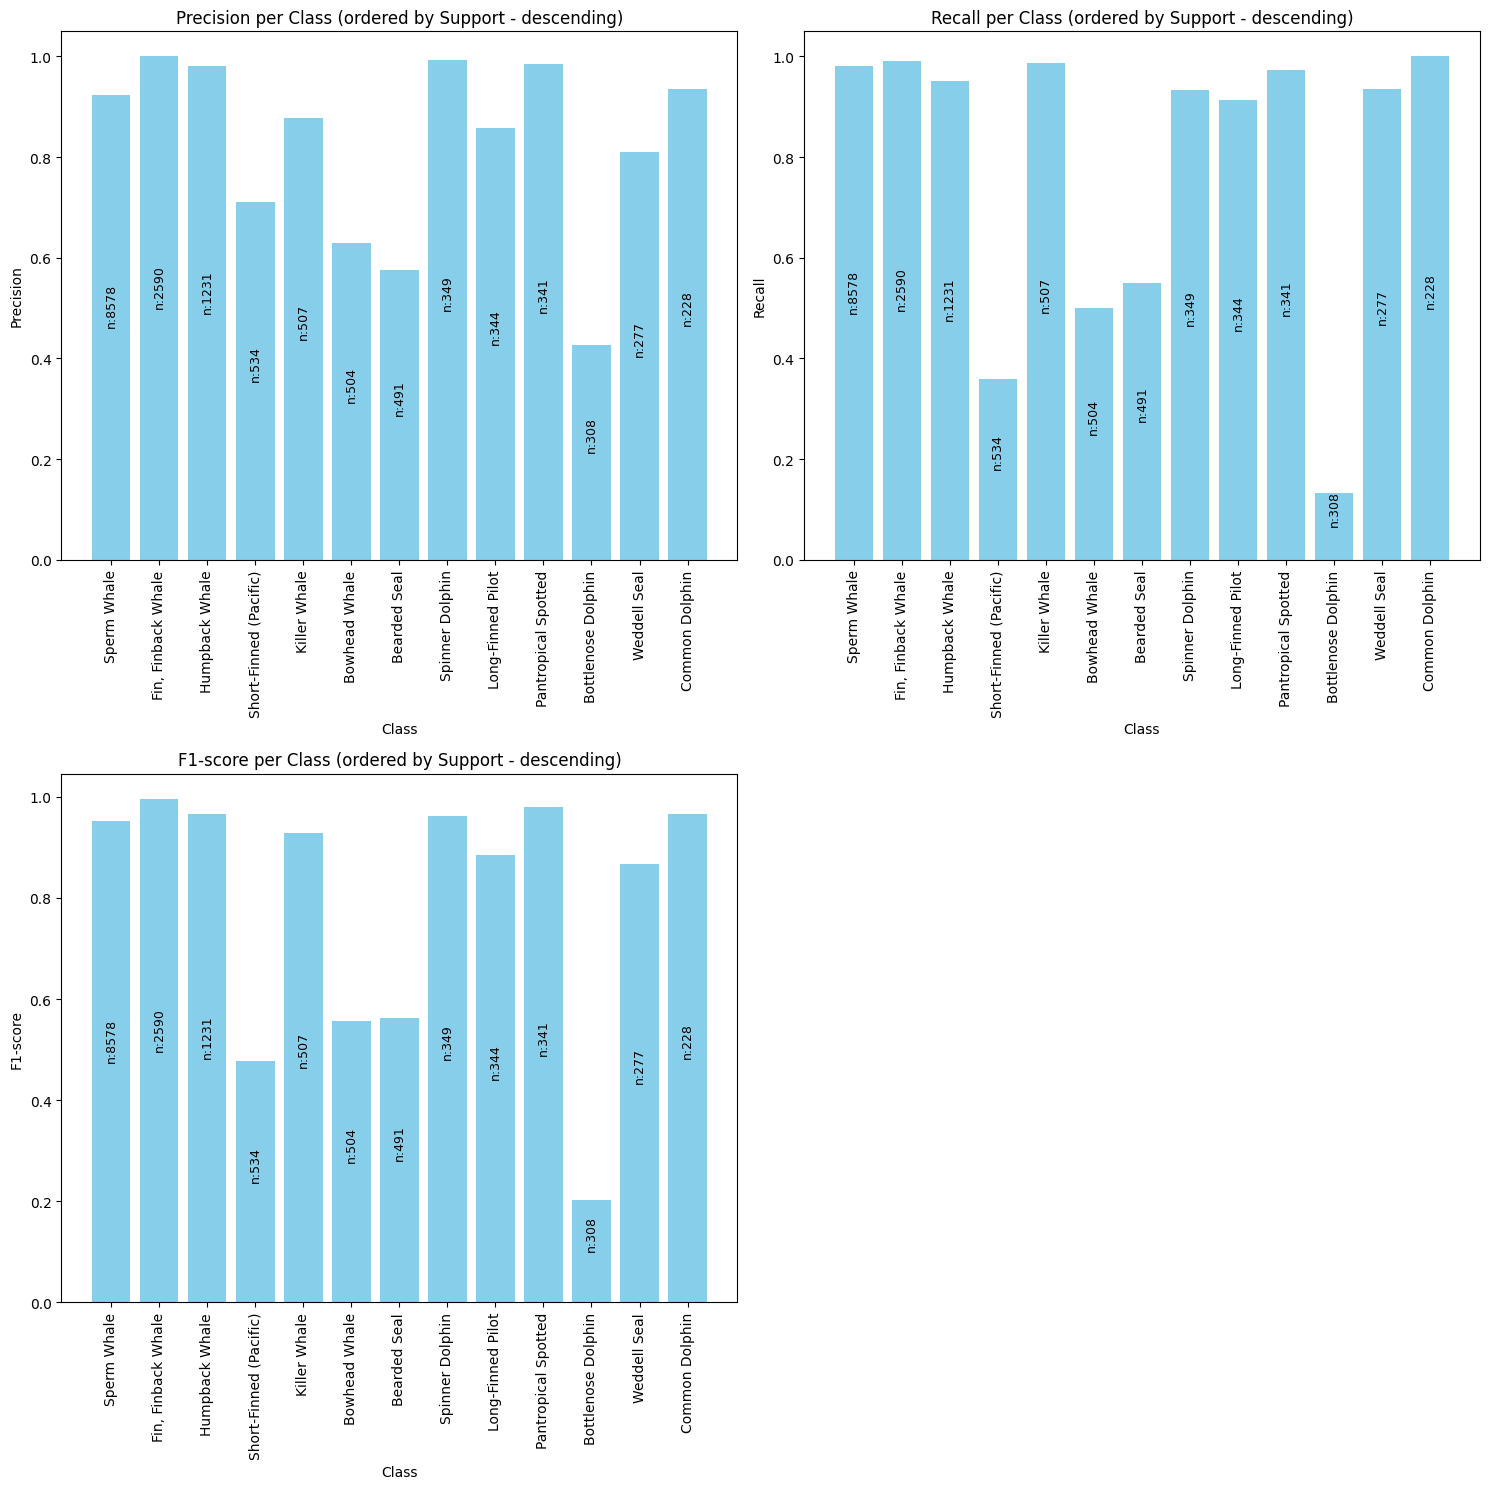

In [18]:
curr_metrics_date = '01-09_merged_metrics'
classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, curr_metrics_date, f'{n_classes_1000}_merged_metrics.csv'))
classes_df_sorted = classes_df.sort_values(by='support', ascending=False)
fig = metrics_plot_builder(classes_df_sorted)
plt.show()

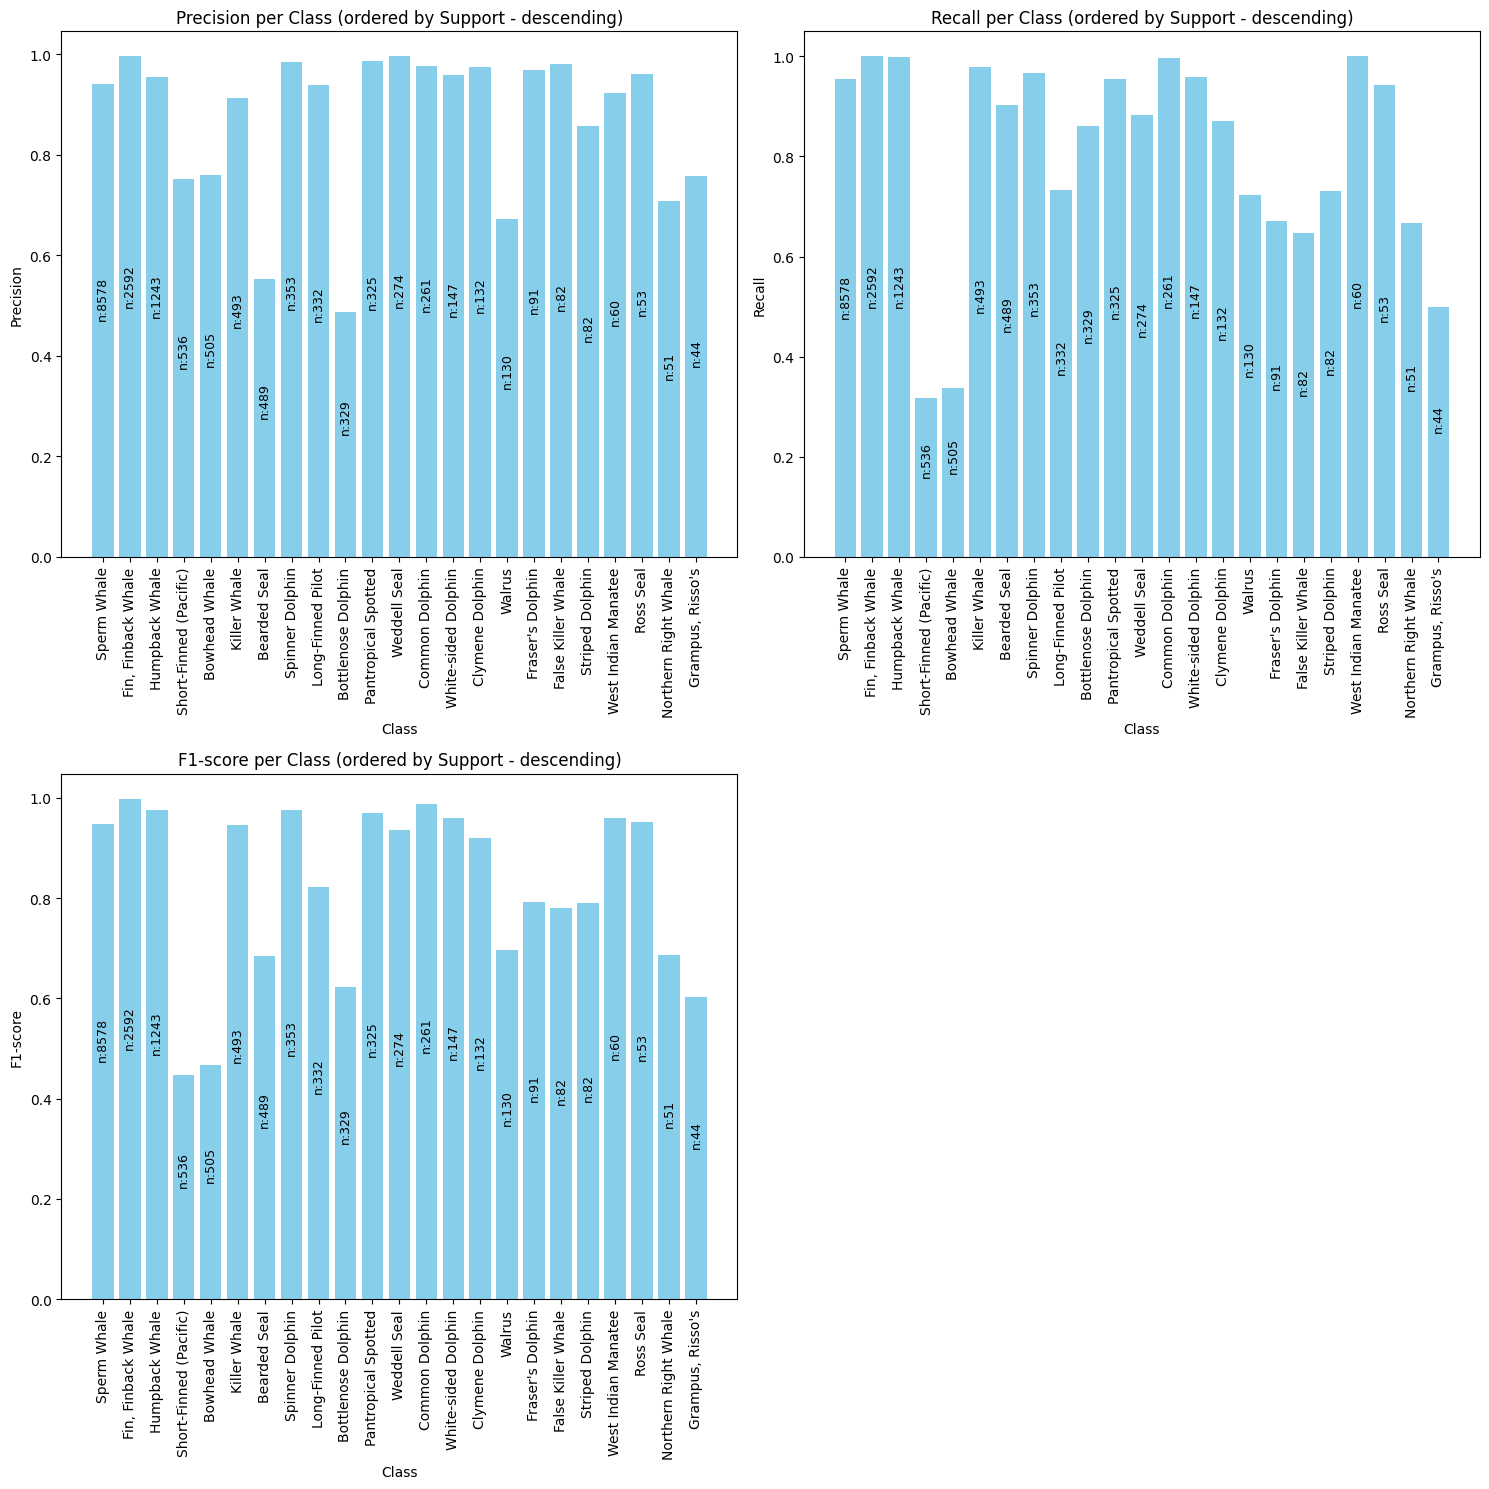

In [14]:
curr_metrics_date = '01-09_merged_metrics'
classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, curr_metrics_date, f'{n_classes_plus_10}_merged_metrics.csv'))
classes_df_sorted = classes_df.sort_values(by='support', ascending=False)
fig = metrics_plot_builder(classes_df_sorted)
plt.show()

In [ ]:
curr_metrics_date = '01-09_merged_metrics'
classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, curr_metrics_date, f'{n_classes_plus_20}_merged_metrics.csv'))
classes_df_sorted = classes_df.sort_values(by='support', ascending=False)
fig = metrics_plot_builder(classes_df_sorted)
plt.show()

In [ ]:
curr_metrics_date = '01-09_merged_metrics'
classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, curr_metrics_date, f'{n_classes_plus_30}_merged_metrics.csv'))
classes_df_sorted = classes_df.sort_values(by='support', ascending=False)
fig = metrics_plot_builder(classes_df_sorted)
plt.show()

In [ ]:
curr_metrics_date = '01-09_merged_metrics'
classes_df = pd.read_csv(os.path.join(MODELS_METRICS_DIR, curr_metrics_date, f'{n_classes_plus_rem}_merged_metrics.csv'))
classes_df_sorted = classes_df.sort_values(by='support', ascending=False)
fig = metrics_plot_builder(classes_df_sorted)
plt.show()